## Import

In [1]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import json
import matplotlib.pyplot as plt
from IPython.display import display
import os
import numpy as np
import sys 
sys.path.append('../modules')
import data
import eval
from sklearn import preprocessing
from sklearn import pipeline
from sklearn import compose
from sklearn import ensemble
from sklearn import linear_model
from sklearn import feature_selection
from sklearn import model_selection
import xgboost

pd.set_option('display.min_rows', 20)
pd.set_option('display.max_rows', 200)
pd.set_option('display.max_columns', 100)
pd.set_option('display.width', 1000)
pd.set_option('display.colheader_justify', 'center')
pd.set_option('display.precision', 3)



## Load Data

In [7]:
# migration rates
values = data.load_migration_rates_from_csv()

# google trends
trends = data.load_trends_from_csv()

countries = data.get_countries()
keyword_ids = trends.columns.levels[0].tolist()


# panel = pd.concat([values, trends], axis='columns')
panel = values.join(trends, how="outer")
# panel


## Models

### RF - only KW 19

In [13]:
# mlflow.start_run(run_name = "random_forest_kw19")
# mlflow.set_tag("model_class", "ensemble")
# mlflow.set_tag("model_alg", "random_forest")
# mlflow.set_tag("model_alg", "random_forest")

t_min = "2012-01-01"
t_max = "2019-12-01"
t_split_lower = "2017-12-01"
t_split_upper = "2018-01-01"

panel_resampled = panel.resample("3M").mean()
panel_lags = data.create_lags(
    panel_resampled, lags=[1, 2, 3, 4], columns=["19"]
).fillna(0.0)

# define x, y; set minimum value
x = panel_lags.applymap(lambda x: max(x, 0.1))
y = panel_resampled["value"].applymap(lambda x: max(x, 1.0))

# transformation: logdiff
x_trans = np.log(x) - np.log(x.shift(4))
y_trans = np.log(y) - np.log(y.shift(4))

x_train = x_trans[t_min:t_split_lower]
y_train = y_trans[t_min:t_split_lower]
x_test = x_trans[t_split_upper:t_max]
y_test = y_trans[t_split_upper:t_max]

# stacking
x_train_stacked, y_train_stacked = data.stack(x_train, y_train)
x_test_stacked, y_test_stacked = data.stack(x_test, y_test)

cv = model_selection.KFold(n_splits=6, shuffle=False)

ct = compose.make_column_transformer(
    (preprocessing.OneHotEncoder(), ["country"]),
    remainder="passthrough",
    sparse_threshold=0,
)

reg = pipeline.make_pipeline(ct, ensemble.RandomForestRegressor(random_state=0),)

hptuner = model_selection.GridSearchCV(
    reg,
    {
        "randomforestregressor__min_samples_split": [4],
        "randomforestregressor__max_depth": [10],
        "randomforestregressor__ccp_alpha": [0.0],
        "randomforestregressor__min_samples_leaf": [2],
        "randomforestregressor__max_features": ["sqrt"],
    },
    cv=cv,
    scoring=eval.scorer_rmse,
    n_jobs=-1,
)
hptuner.fit(x_train_stacked, y_train_stacked)
reg = hptuner.best_estimator_
display(hptuner.best_params_)


cv_score = eval.score_cv(reg, x_train_stacked, y_train_stacked, cv=cv)
test_score = eval.score_test(reg, x_test_stacked, y_test_stacked)

print("Aggregate CV score:")
display(eval.agg_cv_scores(cv_score, use_quantiles=False))

print("Individual CV scores:")
display(cv_score)

print("Holdout score:")
display(test_score)


{'randomforestregressor__ccp_alpha': 0.0,
 'randomforestregressor__max_depth': 10,
 'randomforestregressor__max_features': 'sqrt',
 'randomforestregressor__min_samples_leaf': 2,
 'randomforestregressor__min_samples_split': 4}

Aggregate CV score:


,mean,std,sem
fit_time,0.100,1.261e-02,5.150e-03
score_time,0.011,9.236e-04,3.771e-04
test_mae,-0.113,3.095e-02,1.263e-02
test_rmse,-0.164,4.948e-02,2.020e-02
test_explained_variance,0.048,2.444e-01,9.976e-02
test_r2_mod,0.043,3.466e-01,1.415e-01


Individual CV scores:


,fit_time,score_time,test_mae,test_rmse,test_explained_variance,test_r2_mod
0,0.098,0.010,-0.167,-0.241,0.169,0.354
1,0.093,0.011,-0.107,-0.174,-0.023,0.155
2,0.120,0.012,-0.118,-0.193,0.236,0.267
3,0.110,0.010,-0.073,-0.100,0.283,0.234
4,0.089,0.011,-0.116,-0.149,0.007,-0.215
5,0.089,0.010,-0.097,-0.130,-0.384,-0.538


Holdout score:


mae                  -0.128
rmse                 -0.304
explained_variance    0.012
r2_mod               -0.021
dtype: float64

### RF: KW 19 + AR

In [63]:
t_min = "2012-01-01"
t_max = "2019-12-01"
t_split_lower = "2017-12-01"
t_split_upper = "2018-01-01"

panel_resampled = panel.resample("3M").mean()
panel_lags = data.create_lags(
    panel_resampled, lags=[1, 2, 3, 4], columns=["19", "value"]
).fillna(0.0)

# define x, y; set minimum value
x = panel_lags.applymap(lambda x: max(x, 0.1))
y = panel_resampled["value"].applymap(lambda x: max(x, 1.0))

# transformation: logdiff
x_trans = np.log(x) - np.log(x.shift(4))
y_trans = np.log(y) - np.log(y.shift(4))

x_train = x_trans[t_min:t_split_lower]
y_train = y_trans[t_min:t_split_lower]
x_test = x_trans[t_split_upper:t_max]
y_test = y_trans[t_split_upper:t_max]

# stacking
x_train_stacked, y_train_stacked = data.stack(x_train, y_train)
x_test_stacked, y_test_stacked = data.stack(x_test, y_test)


cv = model_selection.KFold(n_splits=6, shuffle=False)

ct = compose.make_column_transformer(
    (preprocessing.OneHotEncoder(), ["country"]),
    remainder="passthrough",
    sparse_threshold=0,
    verbose_feature_names_out=False,
)

reg = pipeline.make_pipeline(ct, ensemble.RandomForestRegressor(random_state=0),)

hptuner = model_selection.GridSearchCV(
    reg,
    {
        "randomforestregressor__min_samples_split": [2],
        "randomforestregressor__max_depth": [10],
        "randomforestregressor__ccp_alpha": [0.0],
        "randomforestregressor__min_samples_leaf": [4],
        "randomforestregressor__max_features": ["auto"],
    },
    cv=cv,
    scoring=eval.scorer_rmse,
    n_jobs=-1,
)
hptuner.fit(x_train_stacked, y_train_stacked)
reg = hptuner.best_estimator_
display(hptuner.best_params_)

cv_score = eval.score_cv(reg, x_train_stacked, y_train_stacked, cv=cv)

test_score = eval.score_test(reg, x_test_stacked, y_test_stacked)

print("Aggregate CV score:")
display(eval.agg_cv_scores(cv_score, use_quantiles=False))

print("Individual CV scores:")
display(cv_score)

print("Holdout score:")
display(test_score)


{'randomforestregressor__ccp_alpha': 0.0,
 'randomforestregressor__max_depth': 10,
 'randomforestregressor__max_features': 'auto',
 'randomforestregressor__min_samples_leaf': 4,
 'randomforestregressor__min_samples_split': 2}

Aggregate CV score:


,mean,std,sem
fit_time,0.602,0.101,0.041
score_time,0.035,0.018,0.007
test_mae,-0.079,0.014,0.006
test_rmse,-0.113,0.023,0.009
test_explained_variance,0.441,0.221,0.090
test_r2_mod,0.495,0.244,0.099


Individual CV scores:


,fit_time,score_time,test_mae,test_rmse,test_explained_variance,test_r2_mod
0,0.594,0.031,-0.093,-0.128,0.669,0.817
1,0.585,0.031,-0.080,-0.135,0.417,0.490
2,0.514,0.022,-0.081,-0.124,0.666,0.698
3,0.586,0.071,-0.059,-0.079,0.526,0.525
4,0.797,0.031,-0.094,-0.121,0.229,0.194
5,0.537,0.024,-0.068,-0.091,0.141,0.250


Holdout score:


mae                  -0.109
rmse                 -0.282
explained_variance    0.114
r2_mod                0.122
dtype: float64

#### scores by country

In [67]:
test_scores_c = eval.score_test_countries(reg, x_test, y_test, countries)
print("Holdout scores per country:")
display(test_scores_c.sort_values(by="rmse", ascending=False))

cv_scores_c = eval.score_cv_countries(reg, x_train, y_train, countries, cv)
print("CV scores per country:")
display(eval.agg_cv_scores(cv_scores_c, level=0, use_quantiles=False).sort_values(by=("rmse", "mean"), ascending=False))


Holdout scores per country:


,mae,rmse,explained_variance,r2_mod
CH,-0.015,-0.019,0.384,0.266
AT,-0.028,-0.032,-0.002,0.160
BG,-0.033,-0.039,-0.948,0.192
IT,-0.038,-0.043,-0.095,-0.182
RO,-0.035,-0.043,0.648,0.661
CZ,-0.033,-0.045,0.400,0.295
NL,-0.035,-0.046,-0.200,-0.410
FR,-0.043,-0.050,-1.196,-1.204
GR,-0.044,-0.053,0.460,0.462
PL,-0.048,-0.060,0.068,0.477


CV scores per country:


mae                  rmse                explained_variance                 r2_mod                
    mean   std    sem    mean   std    sem          mean         std    sem      mean     std    sem  
FR -0.041  0.012  0.005 -0.049  0.016  0.006       -0.603        0.810  0.331 -8.268e-03  0.723  0.295
BE -0.046  0.023  0.009 -0.057  0.023  0.009       -0.954        0.690  0.282 -2.355e-02  1.059  0.432
GB -0.048  0.009  0.004 -0.057  0.011  0.004       -0.931        1.894  0.773 -5.388e-01  1.937  0.791
NL -0.059  0.020  0.008 -0.064  0.020  0.008       -0.583        0.573  0.234  1.696e-02  0.497  0.203
IT -0.059  0.029  0.012 -0.066  0.031  0.013       -0.841        1.388  0.567  6.720e-01  0.461  0.188
CH -0.058  0.026  0.011 -0.067  0.032  0.013       -0.837        0.545  0.223 -2.137e-01  0.883  0.360
LU -0.068  0.019  0.008 -0.076  0.023  0.009       -4.083        7.716  3.150  3.129e-01  0.308  0.126
BG -0.067  0.035  0.014 -0.077  0.042  0.017       -1.605        3.289  1.343 -1.116e+00  4.009  1.637
LV -0.069  0.045  0.019 -0.079  0.050  0.020       -1.225        1.091  0.445  5.325e-01  0.363  0.148
SE -0.073  0.018  0.007 -0.081  0.014  0.006       -1.237        3.005  1.227 -9.992e-01  2.363  0.965
RO -0.066  0.030  0.012 -0.081  0.038  0.015       -4.466        6.286  2.566  4.440e-01  0.579  0.236
SK -0.071  0.031  0.013 -0.083  0.034  0.014        0.258        0.390  0.159  3.554e-01  0.382  0.156
CZ -0.071  0.052  0.021 -0.084  0.061  0.025       -0.085        0.927  0.379  5.088e-01  0.354  0.145
PL -0.072  0.039  0.016 -0.088  0.050  0.020       -0.226        1.489  0.608  1.203e-04  1.075  0.439
HU -0.080  0.042  0.017 -0.090  0.046  0.019       -1.783        3.624  1.479  2.731e-01  0.342  0.139
IE -0.074  0.013  0.005 -0.092  0.017  0.007       -1.418        1.730  0.706 -4.349e-01  0.829  0.338
LT -0.076  0.058  0.024 -0.092  0.066  0.027       -0.211        1.230  0.502  5.900e-01  0.205  0.084
GR -0.076  0.031  0.013 -0.100  0.044  0.018       -0.254        1.166  0.476  1.431e-01  0.466  0.190
FI -0.085  0.039  0.016 -0.100  0.044  0.018       -0.258        0.480  0.196 -7.976e-02  0.592  0.242
PT -0.088  0.027  0.011 -0.104  0.032  0.013       -0.452        0.624  0.255  5.887e-01  0.232  0.095
AT -0.085  0.088  0.036 -0.106  0.107  0.044       -0.255        0.409  0.167  1.163e-01  0.407  0.166
ES -0.103  0.054  0.022 -0.119  0.058  0.024       -1.152        0.623  0.255  4.853e-01  0.507  0.207
DK -0.107  0.060  0.024 -0.120  0.064  0.026       -0.718        0.902  0.368 -6.731e-01  0.819  0.334
SI -0.099  0.048  0.020 -0.121  0.050  0.020       -2.936        7.882  3.218  5.385e-01  0.573  0.234
EE -0.113  0.030  0.012 -0.133  0.027  0.011       -0.544        0.847  0.346 -2.176e-01  0.955  0.390
HR -0.156  0.111  0.045 -0.193  0.145  0.059       -1.781        3.966  1.619  4.813e-01  0.537  0.219
CY -0.216  0.102  0.042 -0.247  0.117  0.048       -0.703        0.926  0.378  1.309e-01  0.650  0.265

#### feature importances

In [24]:
# pd.Series(reg.steps[-1][1].feature_importances_[-8:], index=x_train_stacked.columns[1:])
features_names_out = reg.steps[0][1].get_feature_names_out()
pd.Series(reg.steps[-1][1].feature_importances_, index=features_names_out).sort_values(
    ascending=False
)



value_1       7.686e-01
value_4       4.414e-02
value_2       3.880e-02
19_1          3.498e-02
19_3          3.298e-02
19_4          2.868e-02
value_3       2.367e-02
19_2          2.006e-02
country_HR    3.306e-03
country_RO    2.214e-03
country_CY    6.668e-04
country_DK    3.126e-04
country_IT    2.600e-04
country_AT    1.862e-04
country_BG    1.645e-04
country_GR    1.523e-04
country_PT    1.517e-04
country_ES    1.417e-04
country_SE    1.275e-04
country_LT    9.950e-05
country_GB    8.266e-05
country_IE    5.794e-05
country_LV    5.382e-05
country_EE    3.208e-05
country_NL    2.946e-05
country_CZ    2.193e-05
country_LU    5.173e-06
country_CH    4.502e-06
country_PL    0.000e+00
country_SI    0.000e+00
country_SK    0.000e+00
country_FR    0.000e+00
country_FI    0.000e+00
country_BE    0.000e+00
country_HU    0.000e+00
dtype: float64

#### predict

In [64]:
# y predicted over test set
pred_arr_test = reg.predict(x_test_stacked)
y_pred_stacked_test = pd.Series(pred_arr_test, index=x_test_stacked.index)
y_pred_trans_test = y_pred_stacked_test.unstack()

# y predicted over cv
pred_arr_cv = model_selection.cross_val_predict(reg, x_train_stacked, y_train_stacked, cv=cv)
y_pred_stacked_cv = pd.Series(pred_arr_cv, index=x_train_stacked.index)
y_pred_trans_cv = y_pred_stacked_cv.unstack()

y_pred_all = pd.concat([y_pred_trans_cv, y_pred_trans_test])


#### plot prediction (transformed)

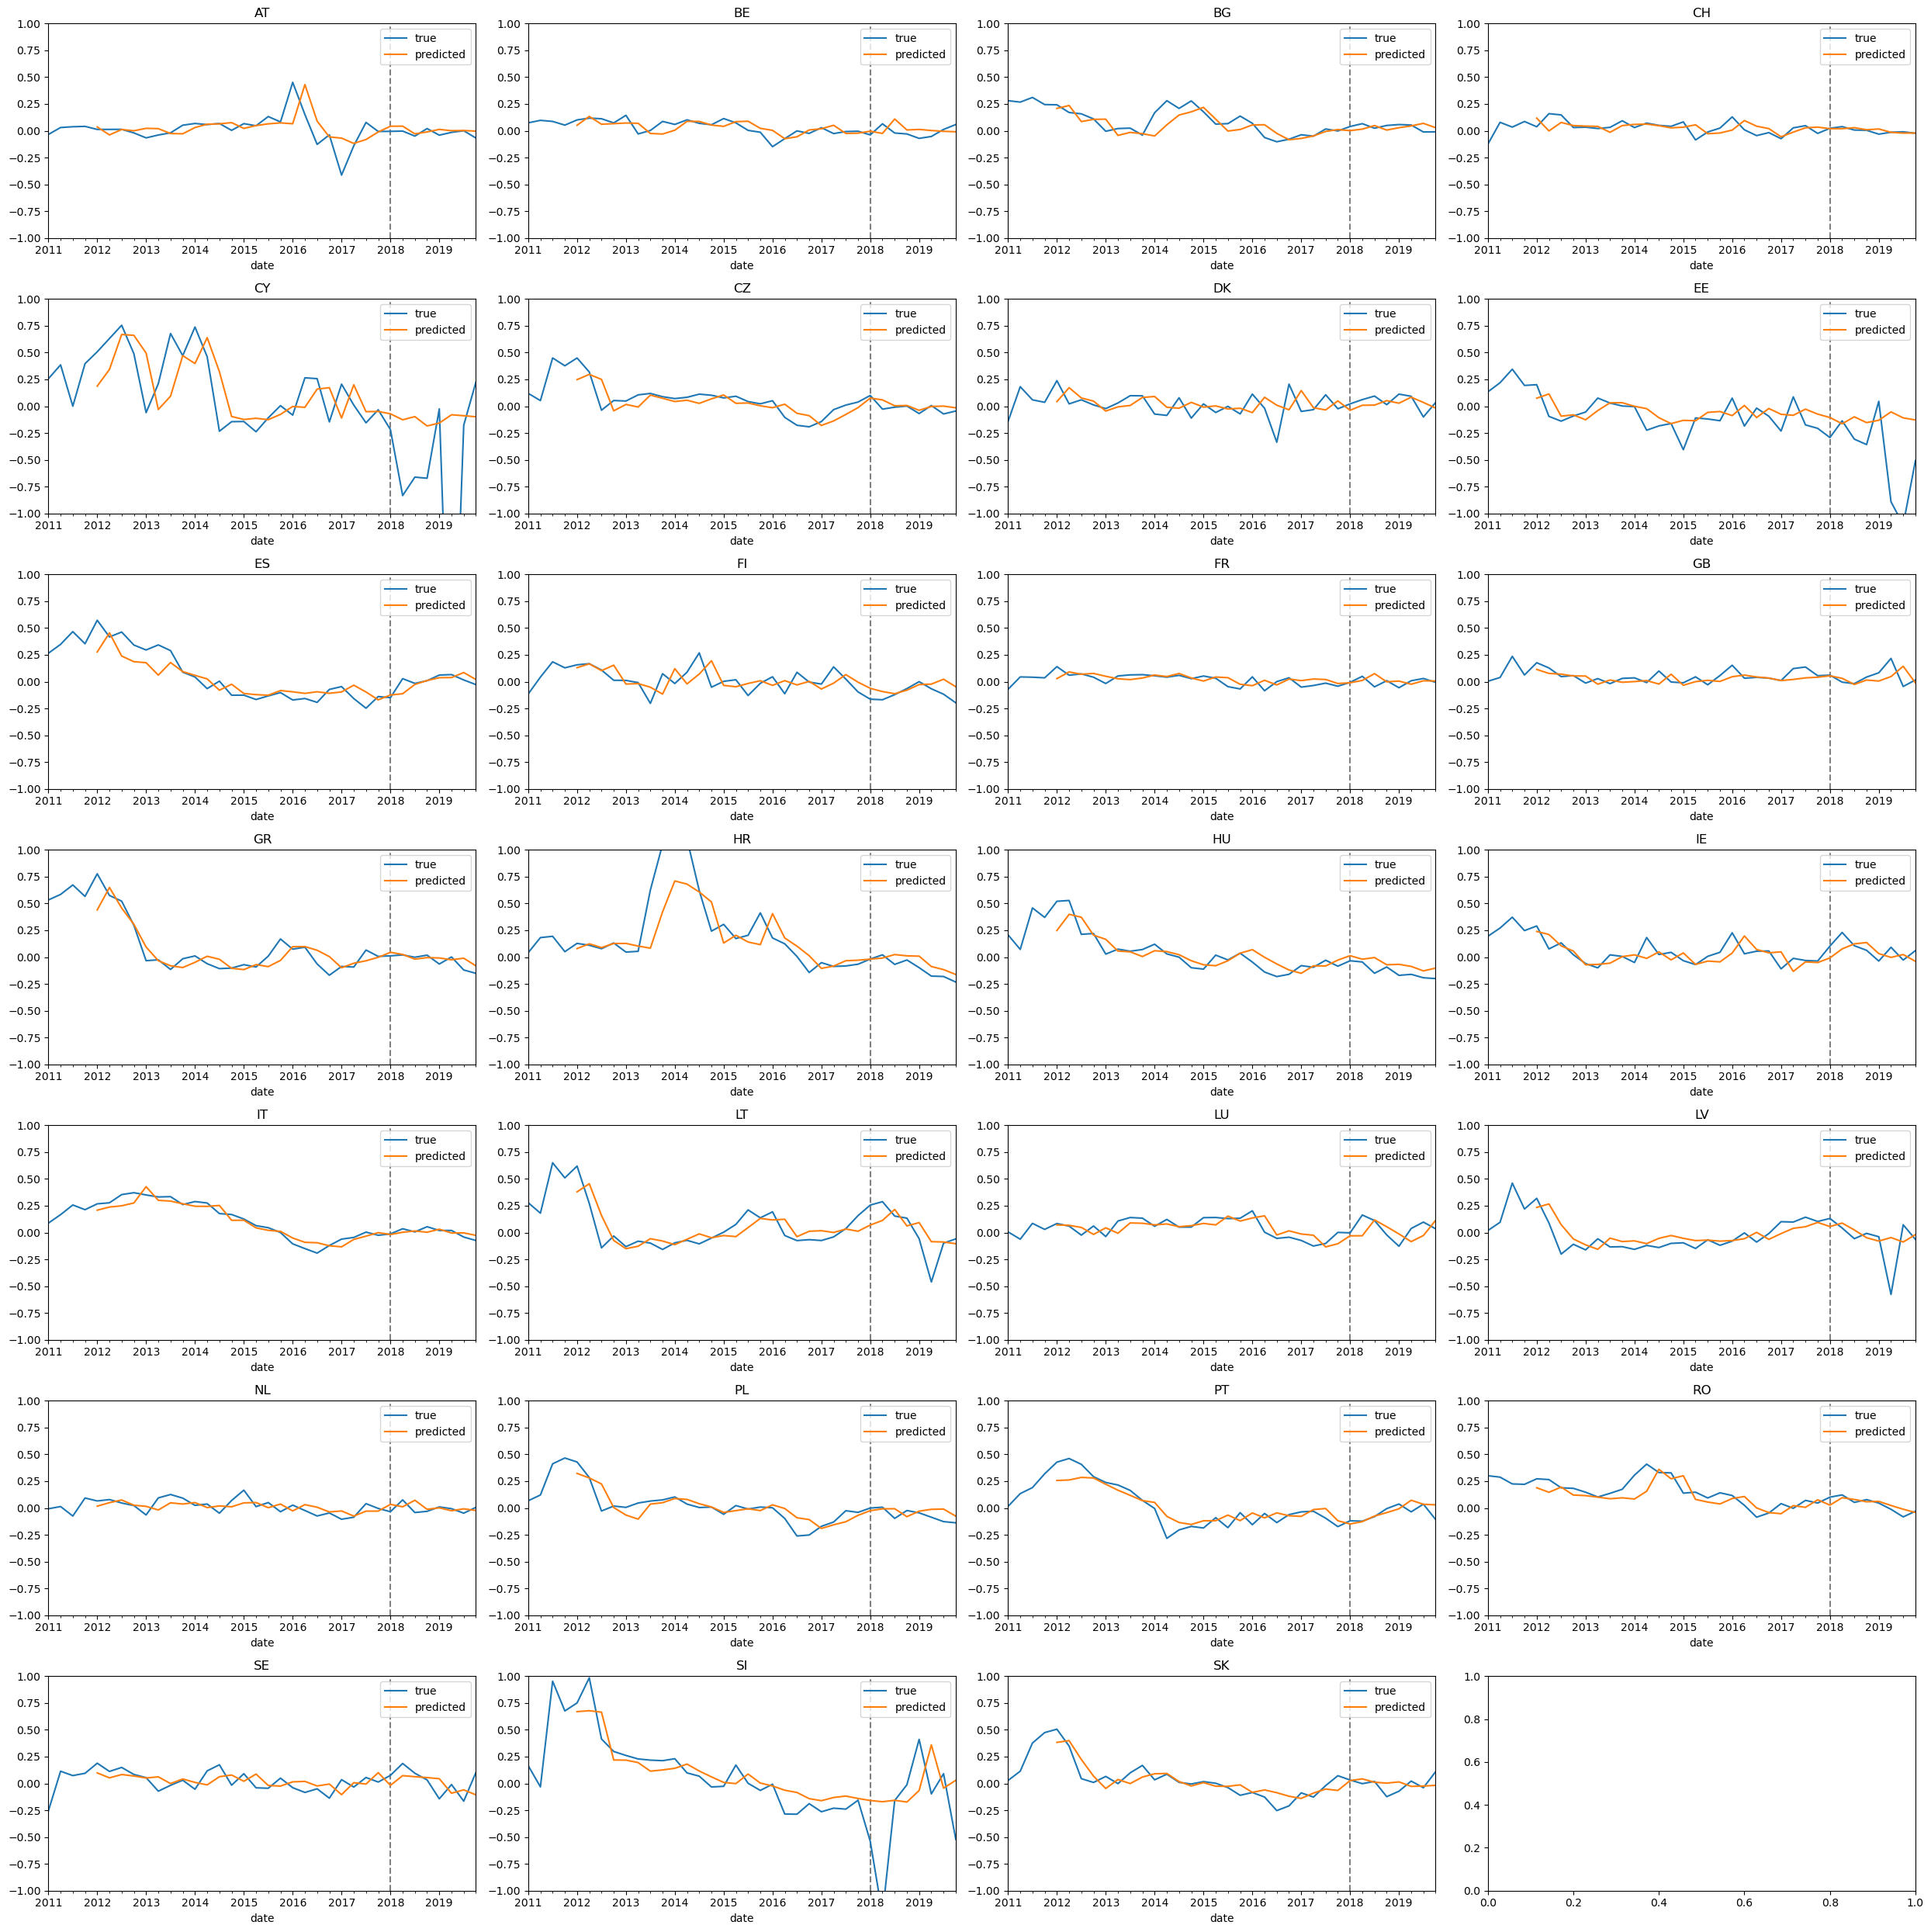

In [65]:
fig, axs = eval.plot_prediction(
    y_pred_all, y_trans, y_min=-1, y_max=1, t_min="2011", vline="2018", t_max="2019"
)
plt.show()


### RF: only AR

In [66]:
t_min = "2012-01-01"
t_max = "2019-12-01"
t_split_lower = "2017-12-01"
t_split_upper = "2018-01-01"

panel_resampled = panel.resample("3M").mean()
panel_lags = data.create_lags(
    panel_resampled, lags=[1, 2, 3, 4], columns=["value"]
).fillna(0.0)

# define x, y; set minimum value
x = panel_lags.applymap(lambda x: max(x, 0.1))
y = panel_resampled["value"].applymap(lambda x: max(x, 1.0))

# transformation: logdiff
x_trans = np.log(x) - np.log(x.shift(4))
y_trans = np.log(y) - np.log(y.shift(4))

x_train = x_trans[t_min:t_split_lower]
y_train = y_trans[t_min:t_split_lower]
x_test = x_trans[t_split_upper:t_max]
y_test = y_trans[t_split_upper:t_max]

# stacking
x_train_stacked, y_train_stacked = data.stack(x_train, y_train)
x_test_stacked, y_test_stacked = data.stack(x_test, y_test)

cv = model_selection.KFold(n_splits=6, shuffle=False)

ct = compose.make_column_transformer(
    (preprocessing.OneHotEncoder(), ["country"]),
    remainder="passthrough",
    sparse_threshold=0,
)

reg = pipeline.make_pipeline(ct, ensemble.RandomForestRegressor(random_state=0),)

hptuner = model_selection.GridSearchCV(
    reg,
    {
        "randomforestregressor__min_samples_split": [2],
        "randomforestregressor__max_depth": [8],
        "randomforestregressor__ccp_alpha": [0.0],
        "randomforestregressor__min_samples_leaf": [4],
        "randomforestregressor__max_features": ["auto"],
    },
    cv=cv,
    scoring=eval.scorer_rmse,
    n_jobs=-1,
)
hptuner.fit(x_train_stacked, y_train_stacked)
reg = hptuner.best_estimator_
display(hptuner.best_params_)

cv_score = eval.score_cv(reg, x_train_stacked, y_train_stacked, cv=cv)

test_score = eval.score_test(reg, x_test_stacked, y_test_stacked)

print("Aggregate CV score:")
display(eval.agg_cv_scores(cv_score, use_quantiles=False))

print("Individual CV scores:")
display(cv_score)

print("Holdout score:")
display(test_score)


{'randomforestregressor__ccp_alpha': 0.0,
 'randomforestregressor__max_depth': 8,
 'randomforestregressor__max_features': 'auto',
 'randomforestregressor__min_samples_leaf': 4,
 'randomforestregressor__min_samples_split': 2}

Aggregate CV score:


,mean,std,sem
fit_time,0.373,0.137,0.056
score_time,0.022,0.005,0.002
test_mae,-0.083,0.016,0.007
test_rmse,-0.115,0.023,0.009
test_explained_variance,0.418,0.246,0.101
test_r2_mod,0.465,0.275,0.112


Individual CV scores:


,fit_time,score_time,test_mae,test_rmse,test_explained_variance,test_r2_mod
0,0.623,0.024,-0.097,-0.129,0.675,0.815
1,0.301,0.018,-0.090,-0.140,0.399,0.452
2,0.439,0.030,-0.081,-0.121,0.680,0.710
3,0.318,0.018,-0.060,-0.082,0.488,0.486
4,0.277,0.019,-0.100,-0.129,0.136,0.088
5,0.280,0.023,-0.068,-0.092,0.128,0.237


Holdout score:


mae                  -0.108
rmse                 -0.283
explained_variance    0.107
r2_mod                0.115
dtype: float64

### RF: KW 19 + AR + aug

In [89]:
t_min = "2012-01-01"
t_max = "2019-12-01"
t_split_lower = "2017-12-01"
t_split_upper = "2018-01-01"

panel_resampled = panel.rolling("90D").mean()
panel_lags = data.create_lags(
    panel_resampled, lags=[3, 6, 9, 12], columns=["19", "value"]
).fillna(0.0)

# define x, y; set minimum value
x = panel_lags.applymap(lambda x: max(x, 0.1))
y = panel_resampled["value"].applymap(lambda x: max(x, 1.0))

# transformation: logdiff
x_trans = np.log(x) - np.log(x.shift(12))
y_trans = np.log(y) - np.log(y.shift(12))

test_dates = [
    "2018-01-01",
    "2018-04-01",
    "2018-07-01",
    "2018-10-01",
    "2019-01-01",
    "2019-04-01",
    "2019-07-01",
    "2019-10-01",
]

x_train = x_trans[t_min:t_split_lower]
y_train = y_trans[t_min:t_split_lower]
x_test = x_trans.loc[test_dates]
y_test = y_trans.loc[test_dates]

# stacking
x_train_stacked, y_train_stacked = data.stack(x_train, y_train)
x_test_stacked, y_test_stacked = data.stack(x_test, y_test)

cv = model_selection.KFold(n_splits=6)

ct = compose.make_column_transformer(
    (preprocessing.OneHotEncoder(), ["country"]),
    remainder="passthrough",
    sparse_threshold=0,
)

reg = pipeline.make_pipeline(ct, ensemble.RandomForestRegressor(random_state=0),)

hptuner = model_selection.GridSearchCV(
    reg,
    {
        "randomforestregressor__min_samples_split": [2],
        "randomforestregressor__max_depth": [8],
        "randomforestregressor__ccp_alpha": [0.0],
        "randomforestregressor__min_samples_leaf": [4],
        "randomforestregressor__max_features": ["auto"],
    },
    cv=cv,
    scoring=eval.scorer_rmse,
    n_jobs=-1,
)
hptuner.fit(x_train_stacked, y_train_stacked)
reg = hptuner.best_estimator_
display(hptuner.best_params_)

cv_score = eval.score_cv(reg, x_train_stacked, y_train_stacked, cv=cv)

test_score = eval.score_test(reg, x_test_stacked, y_test_stacked)

print("Aggregate CV score:")
display(eval.agg_cv_scores(cv_score, use_quantiles=False))

print("Individual CV scores:")
display(cv_score)

print("Holdout score:")
display(test_score)


{'randomforestregressor__ccp_alpha': 0.0,
 'randomforestregressor__max_depth': 8,
 'randomforestregressor__max_features': 'auto',
 'randomforestregressor__min_samples_leaf': 4,
 'randomforestregressor__min_samples_split': 2}

Aggregate CV score:


,mean,std,sem
fit_time,0.516,3.589e-02,1.465e-02
score_time,0.012,9.693e-04,3.957e-04
test_mae,-0.077,1.382e-02,5.640e-03
test_rmse,-0.111,2.409e-02,9.837e-03
test_explained_variance,0.458,1.801e-01,7.351e-02
test_r2_mod,0.504,2.141e-01,8.739e-02


Individual CV scores:


,fit_time,score_time,test_mae,test_rmse,test_explained_variance,test_r2_mod
0,0.552,0.012,-0.093,-0.132,0.616,0.771
1,0.520,0.013,-0.081,-0.135,0.503,0.543
2,0.566,0.012,-0.083,-0.124,0.668,0.696
3,0.487,0.011,-0.060,-0.081,0.467,0.468
4,0.488,0.011,-0.086,-0.114,0.232,0.193
5,0.483,0.010,-0.061,-0.083,0.259,0.356


Holdout score:


mae                  -0.110
rmse                 -0.284
explained_variance    0.104
r2_mod                0.107
dtype: float64

#### predict

In [90]:
# y predicted over test set
pred_arr_test = reg.predict(x_test_stacked)
y_pred_stacked_test = pd.Series(pred_arr_test, index=x_test_stacked.index)
y_pred_trans_test = y_pred_stacked_test.unstack()

# y predicted over cv
pred_arr_cv = model_selection.cross_val_predict(reg, x_train_stacked, y_train_stacked, cv=cv)
y_pred_stacked_cv = pd.Series(pred_arr_cv, index=x_train_stacked.index)
y_pred_trans_cv = y_pred_stacked_cv.unstack()

y_pred_all = pd.concat([y_pred_trans_cv, y_pred_trans_test])


#### plot prediction (transformed)

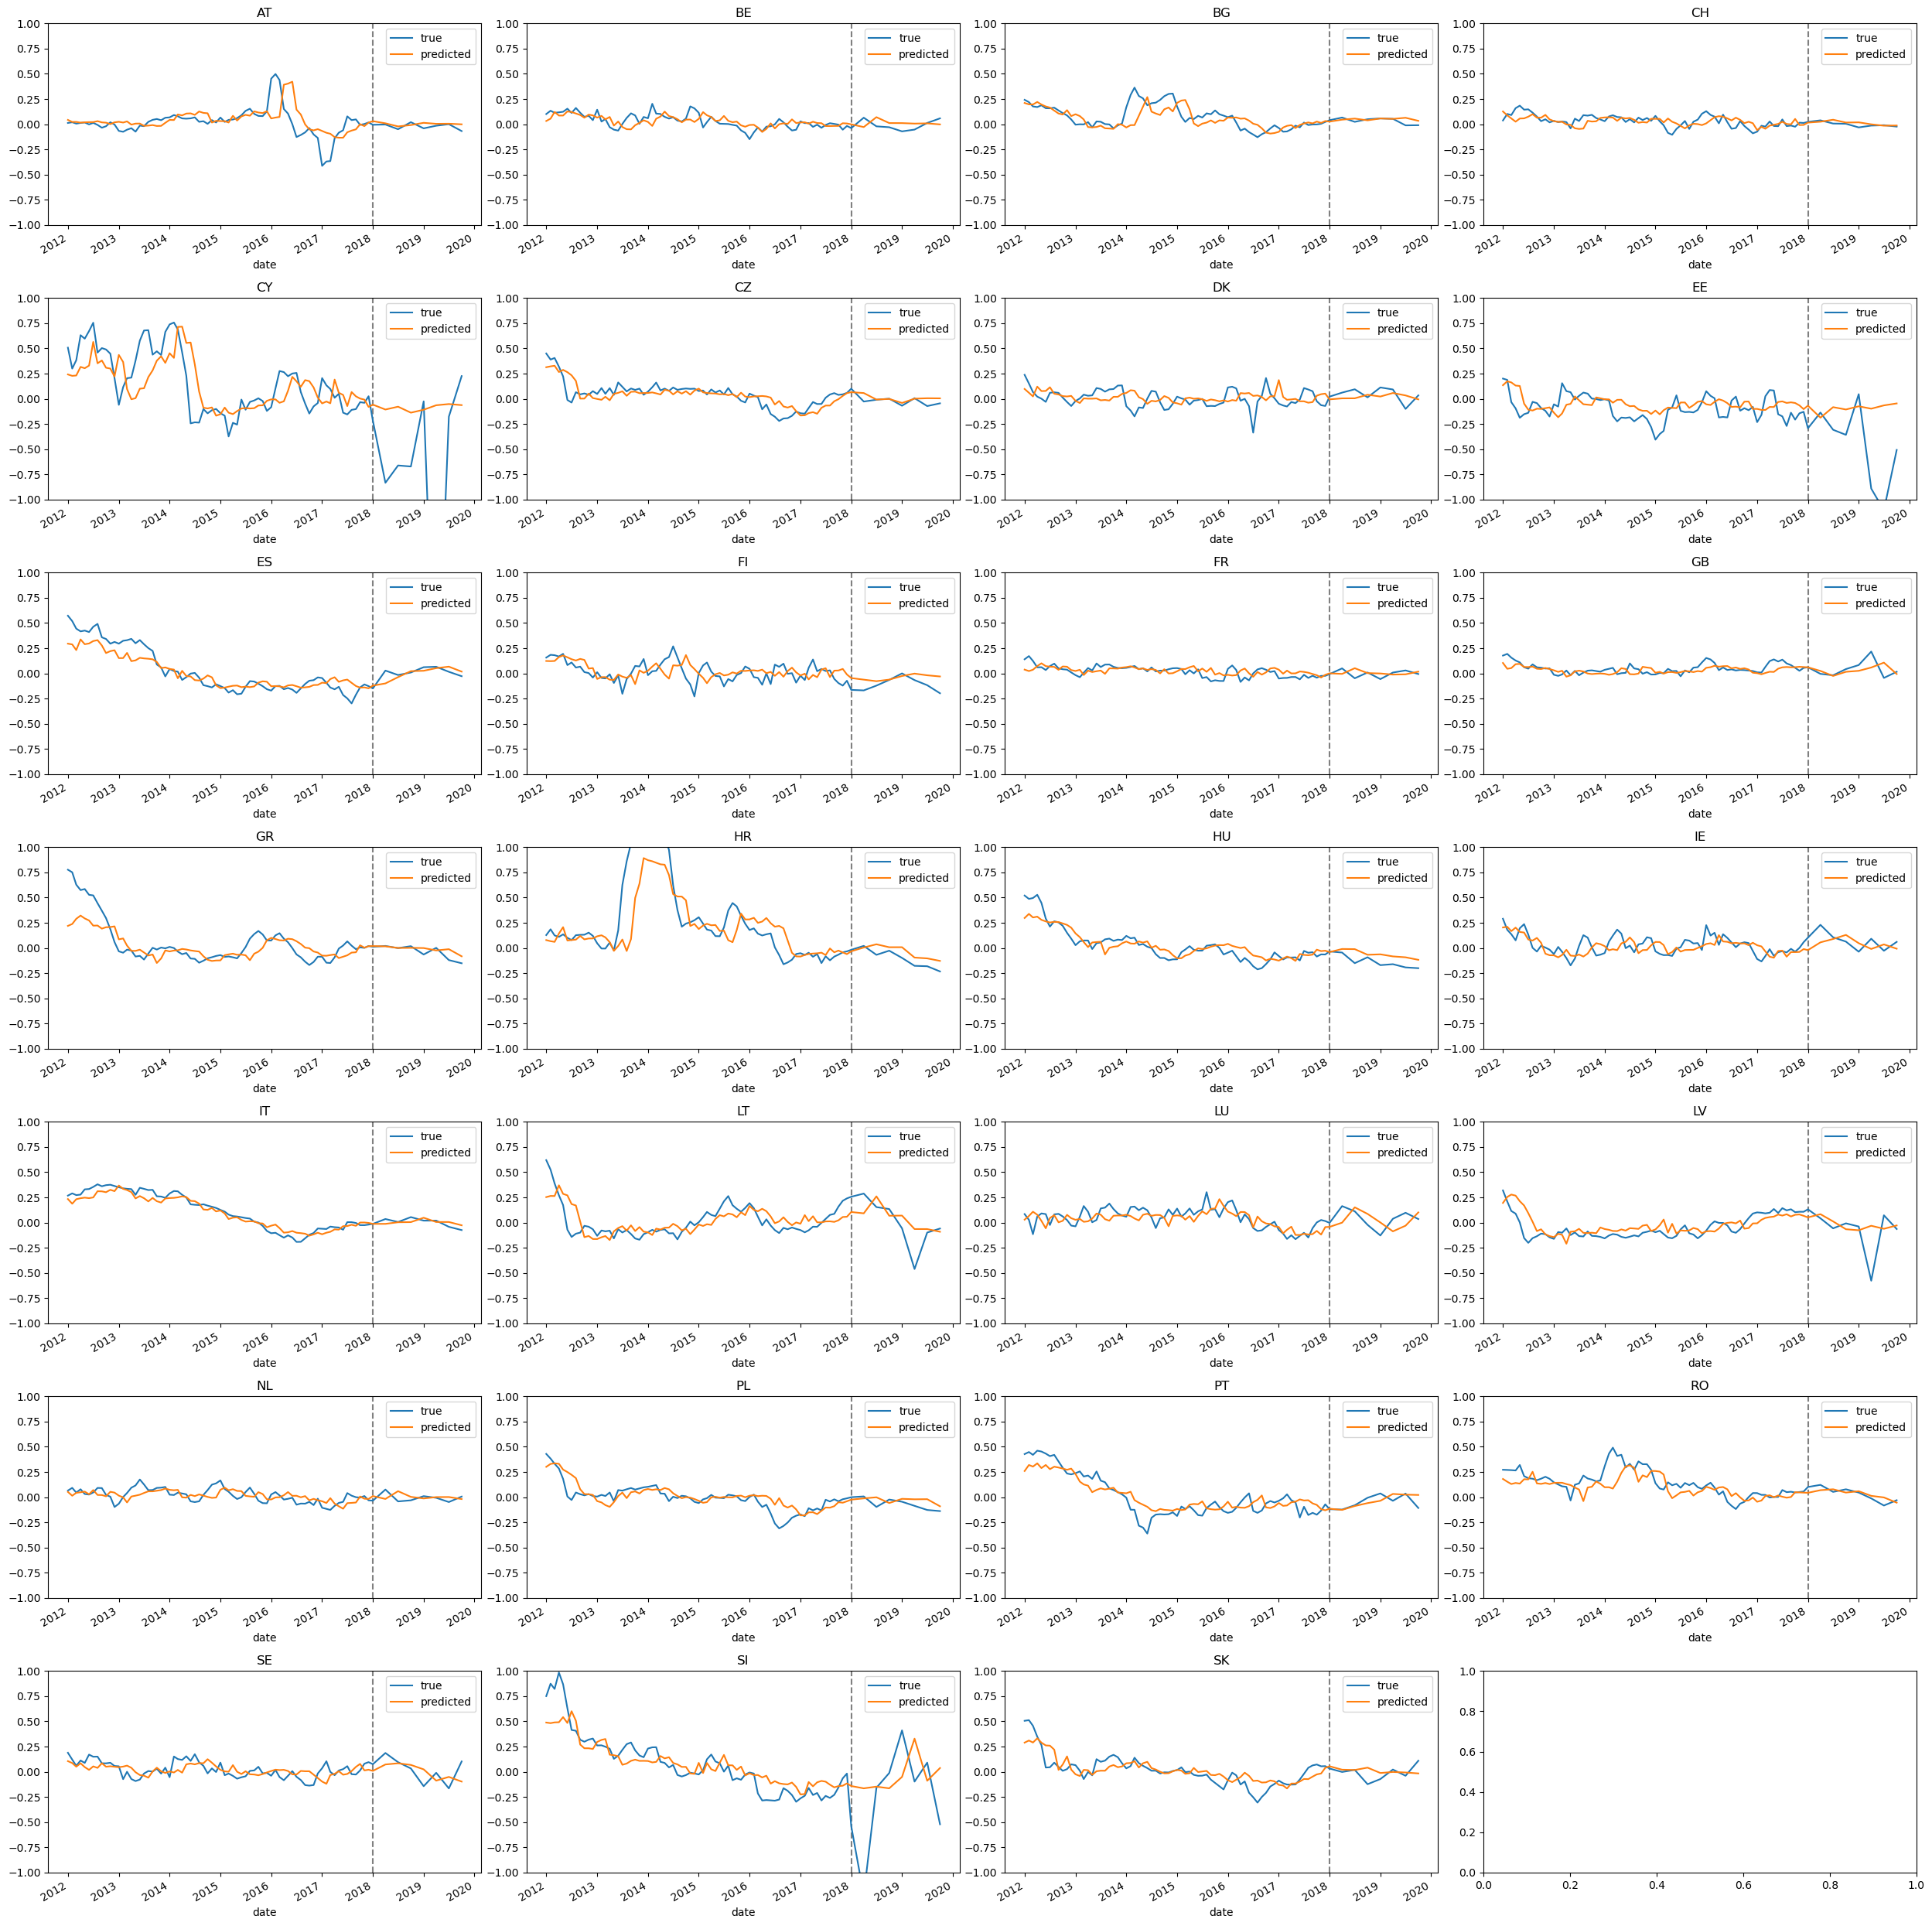

In [91]:
fig, axs = eval.plot_prediction(
    y_pred_all, y_trans, y_min=-1, y_max=1, t_min="2011", vline="2018", t_max="2019"
)
plt.show()


### RF: KW 19 + aug

In [88]:
t_min = "2012-01-01"
t_max = "2019-12-01"
t_split_lower = "2017-12-01"
t_split_upper = "2018-01-01"

panel_resampled = panel.rolling("90D").mean()
panel_lags = data.create_lags(
    panel_resampled, lags=[3, 6, 9, 12], columns=["value"]
).fillna(0.0)

# define x, y; set minimum value
x = panel_lags.applymap(lambda x: max(x, 0.1))
y = panel_resampled["value"].applymap(lambda x: max(x, 1.0))

# transformation: logdiff
x_trans = np.log(x) - np.log(x.shift(12))
y_trans = np.log(y) - np.log(y.shift(12))

test_dates = [
    "2018-01-01",
    "2018-04-01",
    "2018-07-01",
    "2018-10-01",
    "2019-01-01",
    "2019-04-01",
    "2019-07-01",
    "2019-10-01",
]

x_train = x_trans[t_min:t_split_lower]
y_train = y_trans[t_min:t_split_lower]
x_test = x_trans.loc[test_dates]
y_test = y_trans.loc[test_dates]

# stacking
x_train_stacked, y_train_stacked = data.stack(x_train, y_train)
x_test_stacked, y_test_stacked = data.stack(x_test, y_test)

cv = model_selection.KFold(n_splits=6)

ct = compose.make_column_transformer(
    (preprocessing.OneHotEncoder(), ["country"]),
    remainder="passthrough",
    sparse_threshold=0,
)

reg = pipeline.make_pipeline(ct, ensemble.RandomForestRegressor(random_state=0),)

hptuner = model_selection.GridSearchCV(
    reg,
    {
        "randomforestregressor__min_samples_split": [2],
        "randomforestregressor__max_depth": [8],
        "randomforestregressor__ccp_alpha": [0.0],
        "randomforestregressor__min_samples_leaf": [4],
        "randomforestregressor__max_features": ["auto"],
    },
    cv=cv,
    scoring=eval.scorer_rmse,
    n_jobs=-1,
)
hptuner.fit(x_train_stacked, y_train_stacked)
reg = hptuner.best_estimator_
display(hptuner.best_params_)

cv_score = eval.score_cv(reg, x_train_stacked, y_train_stacked, cv=cv)

test_score = eval.score_test(reg, x_test_stacked, y_test_stacked)

print("Aggregate CV score:")
display(eval.agg_cv_scores(cv_score, use_quantiles=False))

print("Individual CV scores:")
display(cv_score)

print("Holdout score:")
display(test_score)


{'randomforestregressor__ccp_alpha': 0.0,
 'randomforestregressor__max_depth': 8,
 'randomforestregressor__max_features': 'auto',
 'randomforestregressor__min_samples_leaf': 4,
 'randomforestregressor__min_samples_split': 2}

Aggregate CV score:


,mean,std,sem
fit_time,0.391,0.116,0.047
score_time,0.013,0.004,0.002
test_mae,-0.079,0.013,0.005
test_rmse,-0.112,0.023,0.009
test_explained_variance,0.446,0.205,0.084
test_r2_mod,0.489,0.239,0.098


Individual CV scores:


,fit_time,score_time,test_mae,test_rmse,test_explained_variance,test_r2_mod
0,0.330,0.012,-0.092,-0.130,0.627,0.777
1,0.348,0.012,-0.084,-0.137,0.499,0.530
2,0.318,0.011,-0.082,-0.120,0.692,0.717
3,0.357,0.011,-0.062,-0.083,0.441,0.443
4,0.625,0.022,-0.089,-0.118,0.191,0.140
5,0.369,0.011,-0.063,-0.084,0.225,0.327


Holdout score:


mae                  -0.109
rmse                 -0.285
explained_variance    0.099
r2_mod                0.102
dtype: float64

### RF: AR + all KW

In [37]:
t_min = "2012-01-01"
t_max = "2019-12-01"
t_split_lower = "2017-12-01"
t_split_upper = "2018-01-01"

panel_resampled = panel.resample("3M").mean()
panel_lags = data.create_lags(panel_resampled, lags=[1, 2, 3, 4]).fillna(0.0)

# define x, y; set minimum value
x = panel_lags.applymap(lambda x: max(x, 0.1))
y = panel_resampled["value"].applymap(lambda x: max(x, 1.0))

# transformation: logdiff
x_trans = np.log(x) - np.log(x.shift(4))
y_trans = np.log(y) - np.log(y.shift(4))

x_train = x_trans[t_min:t_split_lower]
y_train = y_trans[t_min:t_split_lower]
x_test = x_trans[t_split_upper:t_max]
y_test = y_trans[t_split_upper:t_max]

# stacking
x_train_stacked, y_train_stacked = data.stack(x_train, y_train)
x_test_stacked, y_test_stacked = data.stack(x_test, y_test)

cv = model_selection.KFold(n_splits=6, shuffle=False)

ct = compose.make_column_transformer(
    (preprocessing.OneHotEncoder(), ["country"]),
    remainder="passthrough",
    sparse_threshold=0,
    verbose_feature_names_out=False,
)

selector = feature_selection.SelectFromModel(
    ensemble.RandomForestRegressor(random_state=42)
)

reg = pipeline.make_pipeline(
    ct, selector, ensemble.RandomForestRegressor(random_state=0),
)

hptuner = model_selection.GridSearchCV(
    reg,
    {
        "selectfrommodel__threshold": [1.0e-3],
        "randomforestregressor__min_samples_split": [2],
        "randomforestregressor__max_depth": [None],
        "randomforestregressor__ccp_alpha": [0.0],
        "randomforestregressor__min_impurity_decrease": [0.0],
        "randomforestregressor__min_samples_leaf": [4],
        "randomforestregressor__max_features": ["auto"],
    },
    cv=cv,
    scoring=eval.scorer_rmse,
    n_jobs=-1,
)
hptuner.fit(x_train_stacked, y_train_stacked)
reg = hptuner.best_estimator_
display(hptuner.best_params_)

cv_score = eval.score_cv(reg, x_train_stacked, y_train_stacked, cv=cv)

test_score = eval.score_test(reg, x_test_stacked, y_test_stacked)

print("Aggregate CV score:")
display(eval.agg_cv_scores(cv_score, use_quantiles=False))

print("Individual CV scores:")
display(cv_score)

print("Holdout score:")
display(test_score)


{'randomforestregressor__ccp_alpha': 0.0,
 'randomforestregressor__max_depth': None,
 'randomforestregressor__max_features': 'auto',
 'randomforestregressor__min_impurity_decrease': 0.0,
 'randomforestregressor__min_samples_leaf': 4,
 'randomforestregressor__min_samples_split': 2,
 'selectfrommodel__threshold': 0.001}

Aggregate CV score:


,mean,std,sem
fit_time,3.893,0.191,7.797e-02
score_time,0.024,0.002,6.698e-04
test_mae,-0.082,0.017,6.930e-03
test_rmse,-0.119,0.027,1.119e-02
test_explained_variance,0.413,0.192,7.840e-02
test_r2_mod,0.472,0.211,8.614e-02


Individual CV scores:


,fit_time,score_time,test_mae,test_rmse,test_explained_variance,test_r2_mod
0,4.268,0.023,-0.106,-0.149,0.600,0.753
1,3.757,0.025,-0.084,-0.139,0.386,0.464
2,3.775,0.022,-0.083,-0.134,0.608,0.645
3,3.821,0.022,-0.059,-0.081,0.502,0.502
4,3.829,0.026,-0.092,-0.119,0.235,0.218
5,3.908,0.024,-0.068,-0.091,0.147,0.252


Holdout score:


mae                  -0.110
rmse                 -0.284
explained_variance    0.096
r2_mod                0.108
dtype: float64

feature importance

In [38]:
# reg.steps[0][1].get_feature_names_out()
features_names_out = reg.steps[1][1].get_feature_names_out(
    reg.steps[0][1].get_feature_names_out()
)
pd.Series(reg.steps[-1][1].feature_importances_, index=features_names_out).sort_values(
    ascending=False
)



value_1       6.661e-01
value_2       1.998e-02
55_2          1.356e-02
117_1         1.156e-02
123_3         1.063e-02
value_4       1.056e-02
19_3          9.315e-03
123_1         7.941e-03
119_3         6.799e-03
112_1         6.619e-03
119_1         6.468e-03
118_2         6.277e-03
value_3       6.196e-03
19_1          6.131e-03
119_4         5.825e-03
115_1         5.436e-03
118_3         5.313e-03
112_3         5.183e-03
122_2         5.175e-03
19_4          4.997e-03
113_3         4.822e-03
115_2         4.723e-03
117_4         4.608e-03
55_4          4.530e-03
114_4         4.469e-03
11_2          4.313e-03
118_4         4.210e-03
118_1         4.206e-03
113_4         4.130e-03
114_1         3.998e-03
113_2         3.880e-03
123_2         3.772e-03
121_2         3.621e-03
119_2         3.572e-03
21_2          3.518e-03
123_4         3.415e-03
125_1         3.354e-03
114_3         3.323e-03
125_3         3.308e-03
24_2          3.275e-03
113_1         3.271e-03
124_4         3.

### GB: AR + all KW

In [39]:
t_min = "2012-01-01"
t_max = "2019-12-01"
t_split_lower = "2017-12-01"
t_split_upper = "2018-01-01"

panel_resampled = panel.resample("3M").mean()
panel_lags = data.create_lags(panel_resampled, lags=[1, 2, 3, 4]).fillna(0.0)

# define x, y; set minimum value
x = panel_lags.applymap(lambda x: max(x, 0.1))
y = panel_resampled["value"].applymap(lambda x: max(x, 1.0))

# transformation: logdiff
x_trans = np.log(x) - np.log(x.shift(4))
y_trans = np.log(y) - np.log(y.shift(4))

x_train = x_trans[t_min:t_split_lower]
y_train = y_trans[t_min:t_split_lower]
x_test = x_trans[t_split_upper:t_max]
y_test = y_trans[t_split_upper:t_max]

# stacking
x_train_stacked, y_train_stacked = data.stack(x_train, y_train)
x_test_stacked, y_test_stacked = data.stack(x_test, y_test)

cv = model_selection.KFold(n_splits=6, shuffle=False)

ct = compose.make_column_transformer(
    (preprocessing.OneHotEncoder(), ["country"]),
    remainder="passthrough",
    sparse_threshold=0,
    verbose_feature_names_out=False,
)

selector = feature_selection.SelectFromModel(
    ensemble.GradientBoostingRegressor(random_state=1)
)

reg = pipeline.make_pipeline(
    ct, selector, ensemble.GradientBoostingRegressor(random_state=0),
)

hptuner = model_selection.GridSearchCV(
    reg,
    {
        "selectfrommodel__threshold": ["mean"],
        "gradientboostingregressor__learning_rate": [0.1],
        "gradientboostingregressor__subsample": [0.9],
        "gradientboostingregressor__min_samples_split": [8],
        "gradientboostingregressor__min_samples_leaf": [8],
        "gradientboostingregressor__max_depth": [3],
    },
    cv=cv,
    scoring=eval.scorer_rmse,
    n_jobs=-1,
)
hptuner.fit(x_train_stacked, y_train_stacked)
reg = hptuner.best_estimator_
display(hptuner.best_params_)

cv_score = eval.score_cv(reg, x_train_stacked, y_train_stacked, cv=cv)

test_score = eval.score_test(reg, x_test_stacked, y_test_stacked)

print("Aggregate CV score:")
display(eval.agg_cv_scores(cv_score, use_quantiles=False))

print("Individual CV scores:")
display(cv_score)

print("Holdout score:")
display(test_score)


{'gradientboostingregressor__learning_rate': 0.1,
 'gradientboostingregressor__max_depth': 3,
 'gradientboostingregressor__min_samples_leaf': 8,
 'gradientboostingregressor__min_samples_split': 8,
 'gradientboostingregressor__subsample': 0.9,
 'selectfrommodel__threshold': 'mean'}

Aggregate CV score:


,mean,std,sem
fit_time,1.464,6.712e-02,2.740e-02
score_time,0.005,5.153e-04,2.104e-04
test_mae,-0.088,1.903e-02,7.769e-03
test_rmse,-0.123,2.981e-02,1.217e-02
test_explained_variance,0.387,2.069e-01,8.447e-02
test_r2_mod,0.438,2.325e-01,9.490e-02


Individual CV scores:


,fit_time,score_time,test_mae,test_rmse,test_explained_variance,test_r2_mod
0,1.599,0.005,-0.115,-0.156,0.546,0.729
1,1.452,0.005,-0.098,-0.150,0.317,0.368
2,1.450,0.004,-0.089,-0.129,0.636,0.671
3,1.417,0.006,-0.063,-0.083,0.508,0.475
4,1.435,0.005,-0.096,-0.125,0.190,0.148
5,1.431,0.005,-0.070,-0.092,0.125,0.236


Holdout score:


mae                  -0.111
rmse                 -0.282
explained_variance    0.107
r2_mod                0.124
dtype: float64

feature importance

In [40]:
# reg.steps[0][1].get_feature_names_out()
features_names_out = reg.steps[1][1].get_feature_names_out(
    reg.steps[0][1].get_feature_names_out()
)
pd.Series(reg.steps[-1][1].feature_importances_, index=features_names_out).sort_values(
    ascending=False
)



value_1    0.648
value_4    0.041
55_2       0.038
value_2    0.031
115_1      0.022
123_3      0.021
19_3       0.020
119_3      0.016
19_1       0.016
24_1       0.016
119_1      0.015
value_3    0.013
118_3      0.012
11_4       0.011
122_3      0.011
21_2       0.010
24_2       0.008
55_4       0.008
118_2      0.008
39_4       0.007
124_2      0.007
122_1      0.006
117_4      0.006
16_3       0.003
117_3      0.003
dtype: float64

### XGB: AR + all KW

In [73]:
t_min = "2012-01-01"
t_max = "2019-12-01"
t_split_lower = "2017-12-01"
t_split_upper = "2018-01-01"

panel_resampled = panel.resample("3M").mean()
panel_lags = data.create_lags(panel_resampled, lags=[1, 2, 3, 4]).fillna(0.0)

# define x, y; set minimum value
x = panel_lags.applymap(lambda x: max(x, 0.1))
y = panel_resampled["value"].applymap(lambda x: max(x, 1.0))

# transformation: logdiff
x_trans = np.log(x) - np.log(x.shift(4))
y_trans = np.log(y) - np.log(y.shift(4))

# xgboost can handle NaNs, so restore them
x_trans = x_trans.replace(0.0, np.nan)

x_train = x_trans[t_min:t_split_lower]
y_train = y_trans[t_min:t_split_lower]
x_test = x_trans[t_split_upper:t_max]
y_test = y_trans[t_split_upper:t_max]

# stacking
x_train_stacked, y_train_stacked = data.stack(x_train, y_train)
x_test_stacked, y_test_stacked = data.stack(x_test, y_test)

cv = model_selection.KFold(n_splits=6, shuffle=False)

ct = compose.make_column_transformer(
    (preprocessing.OneHotEncoder(), ["country"]),
    remainder="passthrough",
    sparse_threshold=0,
    verbose_feature_names_out=False,
)

selector = feature_selection.SelectFromModel(xgboost.XGBRegressor(random_state=42))

reg = pipeline.make_pipeline(ct, selector, xgboost.XGBRegressor(random_state=0),)

hptuner = model_selection.GridSearchCV(
    reg,
    {
        "selectfrommodel__threshold": ["mean"],
        "xgbregressor__learning_rate": [0.2],
        "xgbregressor__min_split_loss": [0],
        "xgbregressor__max_depth": [6],
        "xgbregressor__reg_alpha": [0.00005],
        "xgbregressor__reg_lambda": [1.0],
        "xgbregressor__colsample_bytree": [1.0],
        "xgbregressor__subsample": [1.0],
    },
    cv=cv,
    scoring=eval.scorer_rmse,
    n_jobs=-1,
)
hptuner.fit(x_train_stacked, y_train_stacked)
reg = hptuner.best_estimator_
display(hptuner.best_params_)

cv_score = eval.score_cv(reg, x_train_stacked, y_train_stacked, cv=cv)

test_score = eval.score_test(reg, x_test_stacked, y_test_stacked)

print("Aggregate CV score:")
display(eval.agg_cv_scores(cv_score, use_quantiles=False))

print("Individual CV scores:")
display(cv_score)

print("Holdout score:")
display(test_score)


{'selectfrommodel__threshold': 'mean',
 'xgbregressor__colsample_bytree': 1.0,
 'xgbregressor__learning_rate': 0.2,
 'xgbregressor__max_depth': 6,
 'xgbregressor__min_split_loss': 0,
 'xgbregressor__reg_alpha': 5e-05,
 'xgbregressor__reg_lambda': 1.0,
 'xgbregressor__subsample': 1.0}

Aggregate CV score:


,mean,std,sem
fit_time,2.077,0.132,5.387e-02
score_time,0.020,0.002,9.012e-04
test_mae,-0.088,0.023,9.425e-03
test_rmse,-0.124,0.037,1.506e-02
test_explained_variance,0.377,0.243,9.912e-02
test_r2_mod,0.430,0.258,1.055e-01


Individual CV scores:


,fit_time,score_time,test_mae,test_rmse,test_explained_variance,test_r2_mod
0,2.254,0.023,-0.127,-0.188,0.436,0.604
1,2.001,0.019,-0.084,-0.131,0.439,0.519
2,1.968,0.018,-0.082,-0.117,0.705,0.733
3,2.018,0.019,-0.061,-0.082,0.498,0.487
4,2.237,0.023,-0.101,-0.130,0.124,0.071
5,1.982,0.020,-0.073,-0.096,0.058,0.163


Holdout score:


mae                  -0.112
rmse                 -0.287
explained_variance    0.080
r2_mod                0.093
dtype: float64

feature importance

In [75]:
# reg.steps[0][1].get_feature_names_out()
features_names_out = reg.steps[1][1].get_feature_names_out(
    reg.steps[0][1].get_feature_names_out()
)
pd.Series(reg.steps[-1][1].feature_importances_, index=features_names_out).sort_values(
    ascending=False
)



value_1       6.196e-01
value_4       3.314e-02
16_3          3.280e-02
55_2          2.911e-02
value_2       2.039e-02
119_1         1.840e-02
19_3          1.550e-02
119_3         1.452e-02
39_4          1.237e-02
24_1          1.229e-02
14_2          1.206e-02
21_2          1.146e-02
12_1          1.053e-02
38_4          1.014e-02
49_4          1.005e-02
113_4         9.684e-03
122_4         9.311e-03
24_2          8.361e-03
117_4         8.090e-03
123_2         7.759e-03
49_3          7.588e-03
48_1          7.555e-03
44_2          7.553e-03
48_3          7.493e-03
118_1         7.250e-03
123_4         6.695e-03
115_1         6.279e-03
124_3         6.266e-03
112_4         5.613e-03
20_1          5.255e-03
32_1          4.826e-03
16_1          4.156e-03
country_HR    4.057e-03
113_2         3.967e-03
43_4          3.255e-03
60_2          3.000e-03
41_4          2.929e-03
country_LT    7.233e-04
dtype: float32

### XGB (lin): AR + all KW

In [83]:
t_min = "2012-01-01"
t_max = "2019-12-01"
t_split_lower = "2017-12-01"
t_split_upper = "2018-01-01"

panel_resampled = panel.resample("3M").mean()
panel_lags = data.create_lags(panel_resampled, lags=[1, 2, 3, 4]).fillna(0.0)

# define x, y; set minimum value
x = panel_lags.applymap(lambda x: max(x, 0.1))
y = panel_resampled["value"].applymap(lambda x: max(x, 1.0))

# transformation: logdiff
x_trans = np.log(x) - np.log(x.shift(4))
y_trans = np.log(y) - np.log(y.shift(4))

# xgboost can handle NaNs, so restore them
x_trans = x_trans.replace(0.0, np.nan)

x_train = x_trans[t_min:t_split_lower]
y_train = y_trans[t_min:t_split_lower]
x_test = x_trans[t_split_upper:t_max]
y_test = y_trans[t_split_upper:t_max]

# stacking
x_train_stacked, y_train_stacked = data.stack(x_train, y_train)
x_test_stacked, y_test_stacked = data.stack(x_test, y_test)

cv = model_selection.KFold(n_splits=6, shuffle=False)

ct = compose.make_column_transformer(
    (preprocessing.OneHotEncoder(), ["country"]),
    remainder="passthrough",
    sparse_threshold=0,
    verbose_feature_names_out=False,
)

selector = feature_selection.SelectFromModel(xgboost.XGBRegressor(random_state=42))

reg = pipeline.make_pipeline(
    ct, selector, xgboost.XGBRegressor(random_state=0, booster="gblinear"),
)

hptuner = model_selection.GridSearchCV(
    reg,
    {
        "selectfrommodel__threshold": ["mean"],
        "xgbregressor__reg_alpha": [1e-3],
        "xgbregressor__reg_lambda": [0.0],
        "xgbregressor__feature_selector": ["shuffle"]
    },
    cv=cv,
    scoring=eval.scorer_rmse,
    n_jobs=-1,
)
hptuner.fit(x_train_stacked, y_train_stacked)
reg = hptuner.best_estimator_
display(hptuner.best_params_)

cv_score = eval.score_cv(reg, x_train_stacked, y_train_stacked, cv=cv)

test_score = eval.score_test(reg, x_test_stacked, y_test_stacked)

print("Aggregate CV score:")
display(eval.agg_cv_scores(cv_score, use_quantiles=False))

print("Individual CV scores:")
display(cv_score)

print("Holdout score:")
display(test_score)


{'selectfrommodel__threshold': 'mean',
 'xgbregressor__feature_selector': 'shuffle',
 'xgbregressor__reg_alpha': 0.001,
 'xgbregressor__reg_lambda': 0.0}

Aggregate CV score:


,mean,std,sem
fit_time,2.937,0.575,0.235
score_time,0.035,0.011,0.004
test_mae,-0.083,0.018,0.007
test_rmse,-0.118,0.027,0.011
test_explained_variance,0.413,0.205,0.084
test_r2_mod,0.468,0.226,0.092


Individual CV scores:


,fit_time,score_time,test_mae,test_rmse,test_explained_variance,test_r2_mod
0,2.780,0.031,-0.113,-0.154,0.550,0.734
1,3.034,0.056,-0.085,-0.143,0.359,0.432
2,2.428,0.028,-0.080,-0.118,0.699,0.728
3,3.077,0.038,-0.064,-0.084,0.477,0.460
4,2.362,0.030,-0.090,-0.120,0.262,0.215
5,3.941,0.029,-0.067,-0.092,0.131,0.240


Holdout score:


mae                  -0.128
rmse                 -0.364
explained_variance   -0.522
r2_mod               -0.459
dtype: float64

#### feature importance

In [85]:
# reg.steps[0][1].get_feature_names_out()
features_names_out = reg.steps[1][1].get_feature_names_out(
    reg.steps[0][1].get_feature_names_out()
)
pd.Series(reg.steps[-1][1].feature_importances_, index=features_names_out).sort_values(
    ascending=False
)



value_1       8.045e-01
value_2       1.258e-01
country_HR    5.254e-02
115_1         5.230e-02
19_3          4.588e-02
39_4          3.858e-02
16_3          1.955e-02
21_2          1.806e-02
20_1          1.672e-02
24_1          1.466e-02
49_4          1.159e-02
12_1          9.993e-03
113_4         5.746e-03
48_1          5.609e-03
122_4         5.058e-03
43_4          3.394e-03
16_1          4.031e-04
117_4         1.208e-30
118_1         7.266e-31
123_2         2.682e-31
119_1         6.941e-32
32_1          2.623e-33
44_2          0.000e+00
119_3         0.000e+00
60_2         -1.895e-32
48_3         -2.738e-32
49_3         -3.151e-32
24_2         -3.696e-31
country_LT   -5.009e-31
123_4        -4.344e-29
124_3        -1.163e-28
113_2        -3.861e-03
112_4        -7.204e-03
41_4         -7.786e-03
38_4         -9.458e-03
14_2         -1.258e-02
55_2         -6.029e-02
value_4      -1.292e-01
dtype: float32

#### predict

In [86]:
# y predicted over test set
pred_arr_test = reg.predict(x_test_stacked)
y_pred_stacked_test = pd.Series(pred_arr_test, index=x_test_stacked.index)
y_pred_trans_test = y_pred_stacked_test.unstack()

# y predicted over cv
pred_arr_cv = model_selection.cross_val_predict(reg, x_train_stacked, y_train_stacked, cv=cv)
y_pred_stacked_cv = pd.Series(pred_arr_cv, index=x_train_stacked.index)
y_pred_trans_cv = y_pred_stacked_cv.unstack()

y_pred_all = pd.concat([y_pred_trans_cv, y_pred_trans_test])


#### plot prediction (transformed)

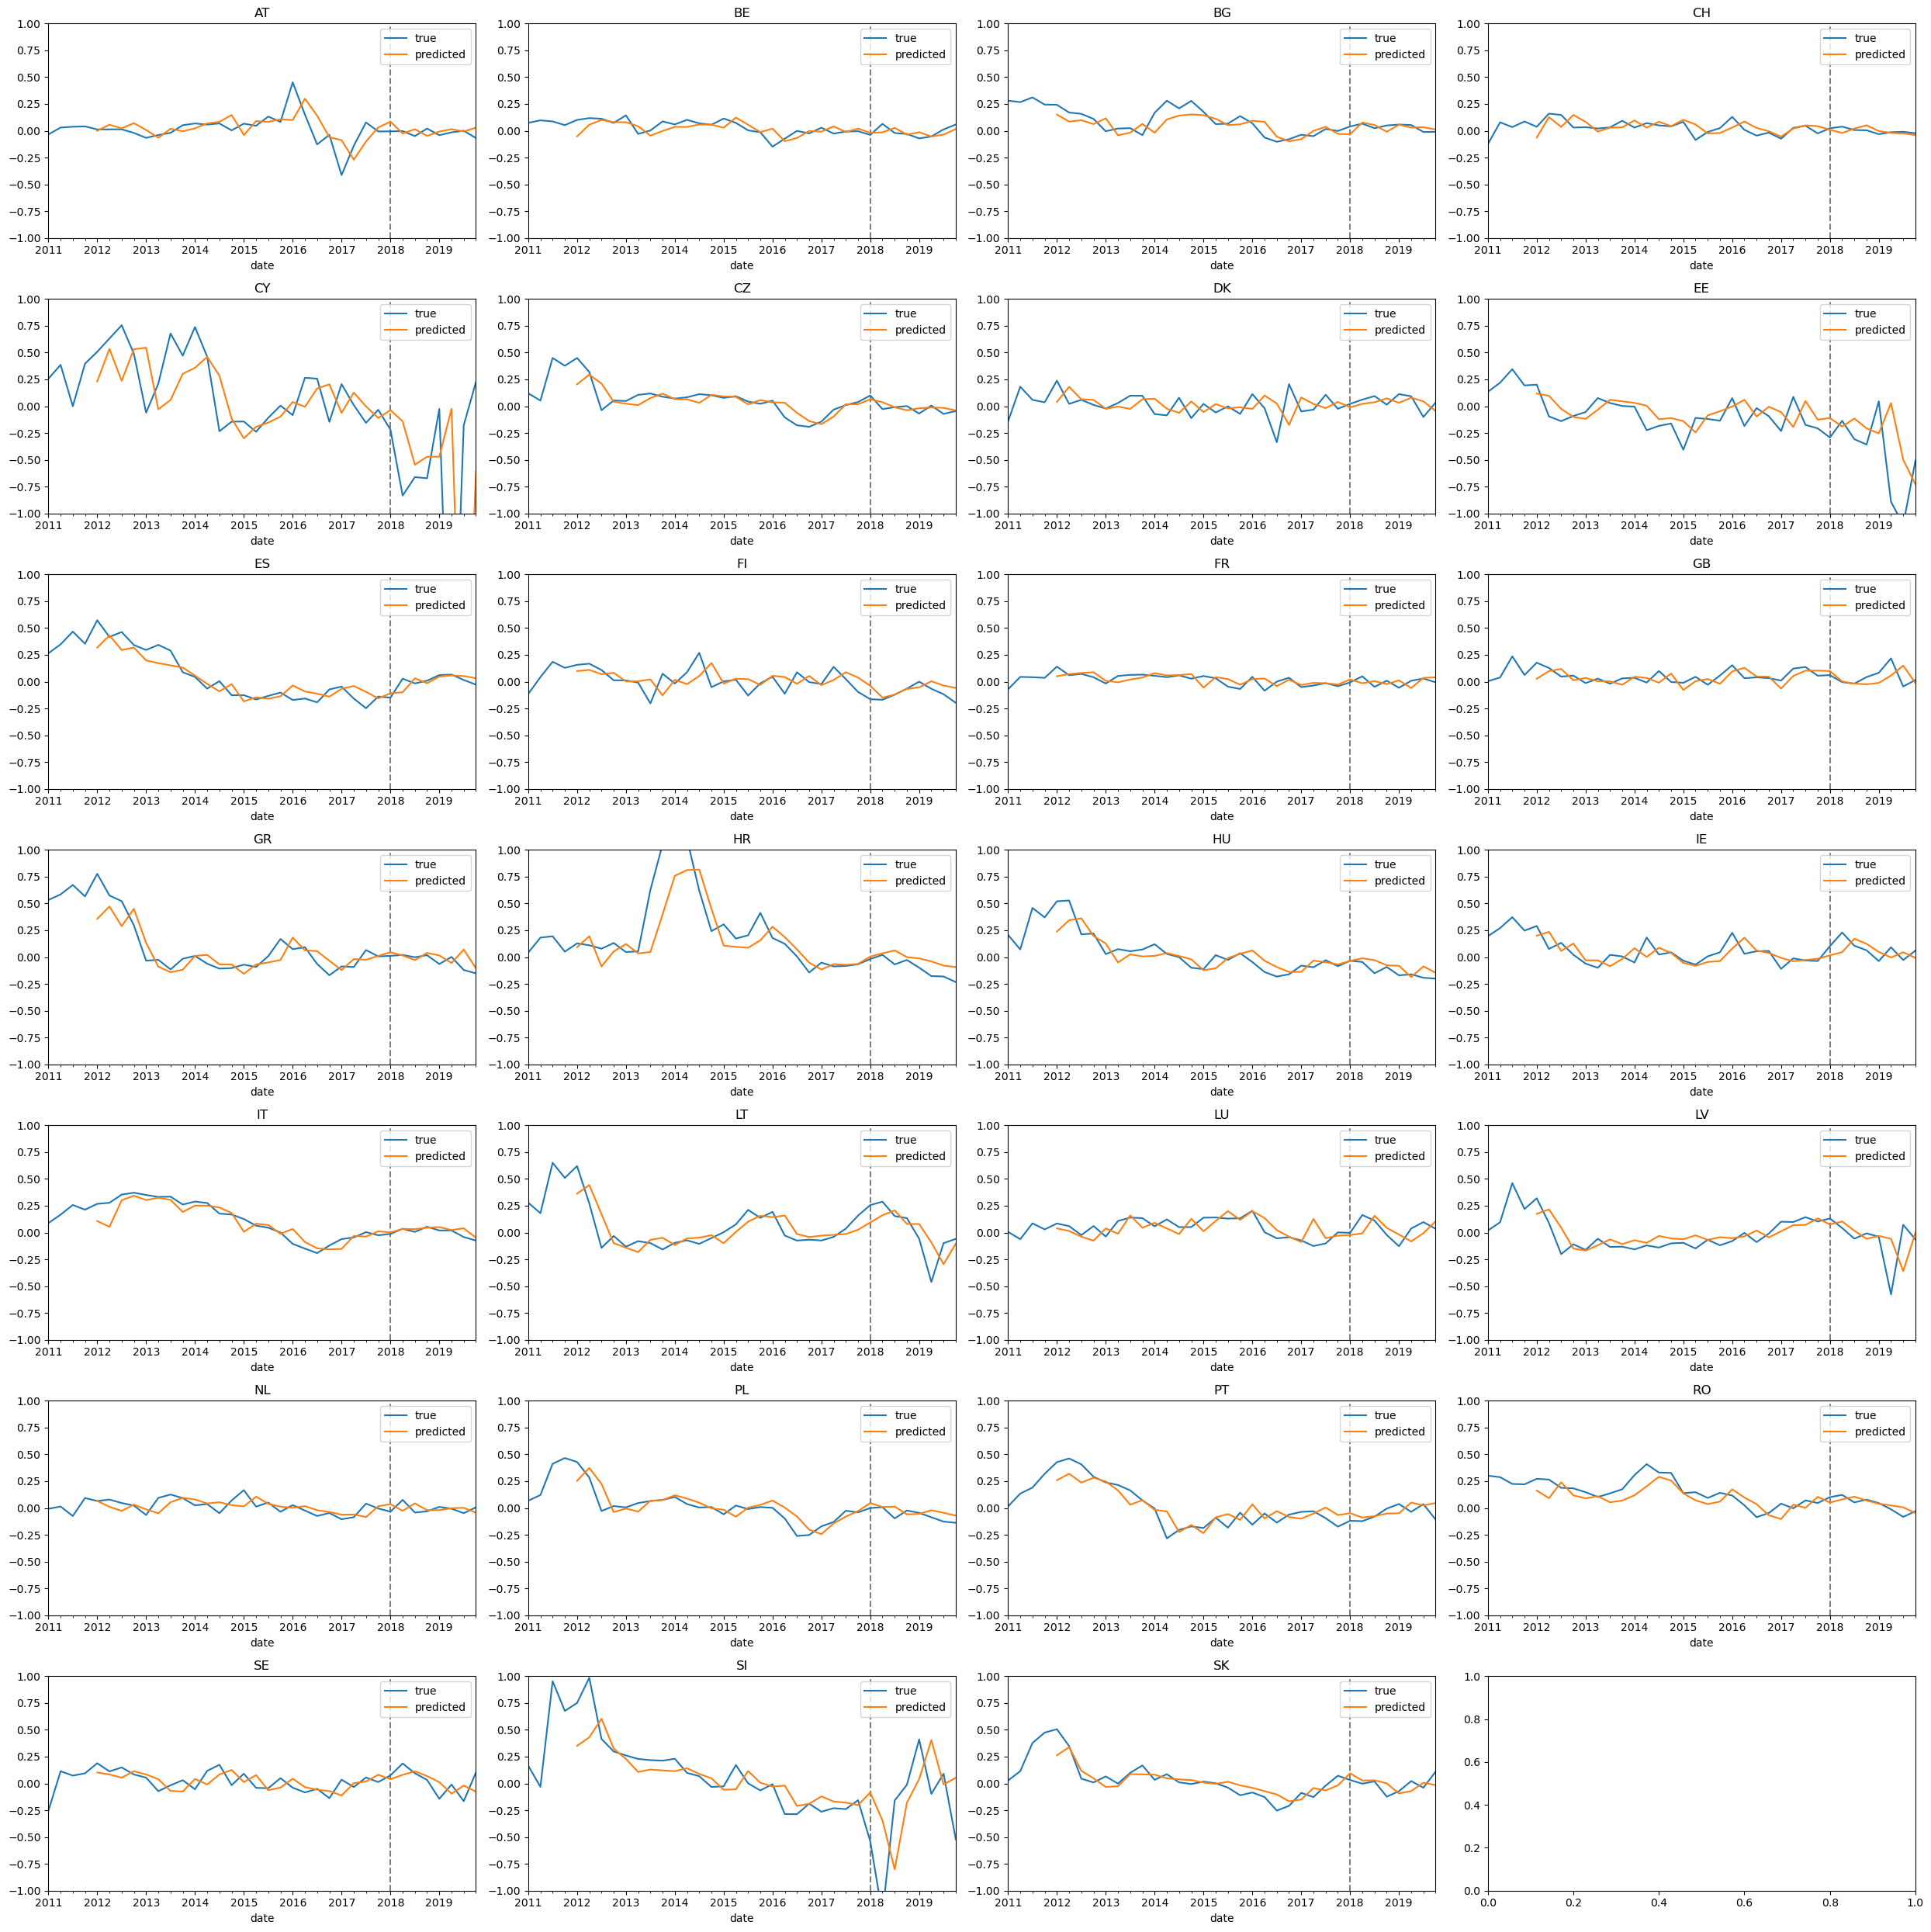

In [87]:
fig, axs = eval.plot_prediction(
    y_pred_all, y_trans, y_min=-1, y_max=1, t_min="2011", vline="2018", t_max="2019"
)
plt.show()
